In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Regression


In [ ]:
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

# define path to save model
model_path = 'regression_model.h5'

In [ ]:
# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv('/content/drive/MyDrive/Project Seminar/Data/data1/PM_train.txt', sep=' ', header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv('/content/drive/MyDrive/Project Seminar/Data/data1/PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv('/content/drive/MyDrive/Project Seminar/Data/data1/PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [ ]:
train_df

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [ ]:
test_df

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699


In [ ]:
truth_df

,0
0,112
1,98
2,69
3,82
4,91
...,...
95,137
96,82
97,59
98,117


## Data Preprocessing

In [ ]:

# TRAIN

rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)


w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()

norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

# TEST
######
# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
print(test_df.head())


rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

# pick a large window size of 50 cycles
sequence_length = 50

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)


val=list(gen_sequence(train_df[train_df['id']==1], sequence_length, sequence_cols))
print(len(val))


seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

# function to generate labels
def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
   
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

   id  cycle  setting1  setting2  setting3   s1        s2        s3        s4  \
0   1      1  0.632184  0.750000       0.0  0.0  0.545181  0.310661  0.269413   
1   1      2  0.344828  0.250000       0.0  0.0  0.150602  0.379551  0.222316   
2   1      3  0.517241  0.583333       0.0  0.0  0.376506  0.346632  0.322248   
3   1      4  0.741379  0.500000       0.0  0.0  0.370482  0.285154  0.408001   
4   1      5  0.580460  0.500000       0.0  0.0  0.391566  0.352082  0.332039   

    s5  ...       s13       s14       s15  s16       s17  s18  s19       s20  \
0  0.0  ...  0.220588  0.132160  0.308965  0.0  0.333333  0.0  0.0  0.558140   
1  0.0  ...  0.264706  0.204768  0.213159  0.0  0.416667  0.0  0.0  0.682171   
2  0.0  ...  0.220588  0.155640  0.458638  0.0  0.416667  0.0  0.0  0.728682   
3  0.0  ...  0.250000  0.170090  0.257022  0.0  0.250000  0.0  0.0  0.666667   
4  0.0  ...  0.220588  0.152751  0.300885  0.0  0.166667  0.0  0.0  0.658915   

        s21  cycle_norm  
0  0.6

(15631, 1)

## LSTM

In [ ]:
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )


nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()
model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae','mse',r2_keras])


print(model.summary())

# fit the network
history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

print(history.history.keys())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50, 100)           50400     
                                                                 
 dropout_6 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_7 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
 activation_3 (Activation)   (None, 1)                 0         
                                                                 
Total params: 80,651
Trainable params: 80,651
Non-trai

## Model Evaluation on Test set

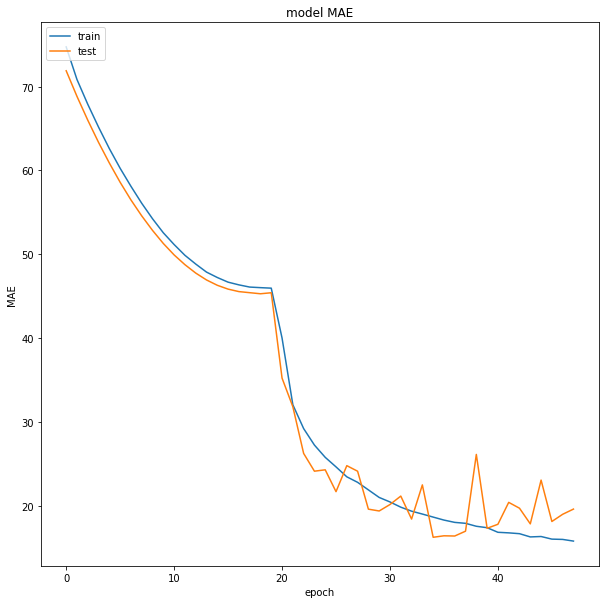

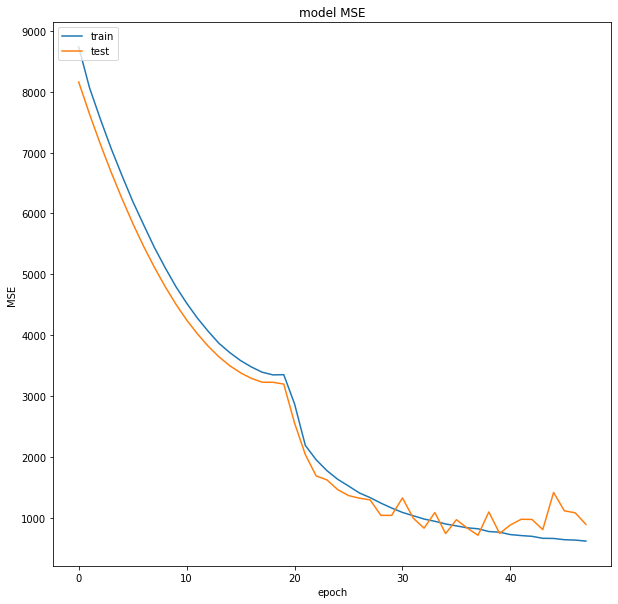

79/79 [==============================] - 1s 8ms/step - loss: 785.7932 - mae: 18.4725 - mse: 785.7932 - r2_keras: 0.6058

MAE: 18.472490310668945

MSE: 785.793212890625
79/79 [==============================] - 1s 7ms/step


In [ ]:

#  MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_mae.png")


#MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_mse.png")


# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nMSE: {}'.format(scores[2]))


y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv('submit_train.csv', index = None)






# # training metrics
# scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
# print('\nMSE: {}'.format(scores[1]))

# y_pred = model.predict(seq_array,verbose=1, batch_size=200)
# y_true = label_array

# test_set = pd.DataFrame(y_pred)
# test_set.to_csv('submit_train1.csv', index = None)

## Evaluate on Validation set

3/3 - 1s - loss: 348.0988 - mae: 12.7706 - mse: 348.0988 - r2_keras: 0.7869 - 1s/epoch - 429ms/step

MAE: 12.770552635192871

MSE: 348.0987854003906


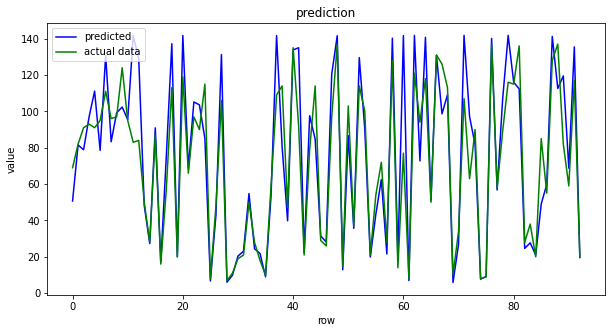

In [ ]:
# We pick the last sequence for each id in the test data
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)


# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras})

    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nMSE: {}'.format(scores_test[2]))

    

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv('submit_test.csv', index = None)

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(y_pred_test, color="blue")
    plt.plot(y_true_test, color="green")
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    fig_verify.savefig("model_regression_verify.png")